In [1]:
import requests
import os
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import warnings
import matplotlib.patches as mpatches

warnings.filterwarnings('ignore')
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

/Users/helenarusso/opt/miniconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
#let's download and import the feature table directly from the FBMN job in GNPS2
task_id = '55122ffb51ab4957be51b0073abc8f04'
response = requests.get(f'https://gnps2.org/result?task={task_id}&viewname=quantificationdownload&resultdisplay_type=task')
directory_path = '/.../directory_path/'

#import the metadata
metadata = pd.read_csv('/.../monocolonized_metadata.txt', sep='\t')
column_interest = 'Bacteria' #this is the column in the metadata table we will work with

with open(directory_path + task_id + '.csv', 'wb') as f:
    f.write(response.content)
    print(f"File saved at {directory_path}")
    
ftable = pd.read_csv(os.path.join(directory_path + task_id + '.csv'), sep=',')
#just keep the column relative to the samples and feature ids.
ftable = ftable[[col for col in ftable.columns if col.endswith('Peak area') or col == 'row ID']]

#import library matches to N-acyl lipids massQL library
library_matches = pd.read_csv('https://gnps2.org/resultfile?task=' + task_id + '&file=nf_output/library/merged_results_with_gnps.tsv', sep='\t')
    
#create another column with simplified annotations:
library_matches['Compound_Name_simplified'] = library_matches['Compound_Name'].str.split('(').str[0]
library_matches['Compound_Name_simplified'] = library_matches['Compound_Name_simplified'].str.replace('Candidate ', '', regex=True)

#create a new column with the scans with a prefix
prefix = 'MS_'
library_matches['MS_#Scan#'] = library_matches['#Scan#'].apply(lambda x: f'{prefix}{x}')


File saved at /Users/helenarusso/Documents/Pesquisa/UCSD Post-doc/Acyl lipids/Examples_lipids/


In [3]:
#filter down the feature table to only have the features that matched the massQL library
list_matches = library_matches['#Scan#'].to_list()
ftable_filtered = ftable[ftable['row ID'].isin(list_matches)]

# formatting table for box plots
ftable_filtered = ftable_filtered.T
ftable_filtered = ftable_filtered.reset_index()
ftable_filtered.columns = ftable_filtered.iloc[0]
ftable_filtered = ftable_filtered[1:]
ftable_filtered = ftable_filtered.add_prefix(prefix)
ftable_filtered = ftable_filtered.rename(columns={'MS_row ID': 'filename'})
ftable_filtered.head()

#remove .mzML/.mzXML from metadata file and ftable
metadata['filename'] = metadata['filename'].apply(lambda x: x.replace('.mzML', '') if x.endswith('.mzML') else x)
metadata['filename'] = metadata['filename'].apply(lambda x: x.replace('.mzXML', '') if x.endswith('.mzXML') else x)

ftable_filtered['filename'] = ftable_filtered['filename'].apply(lambda x: x.replace('.mzML Peak area', '') if x.endswith('.mzML Peak area') else x)
ftable_filtered['filename'] = ftable_filtered['filename'].apply(lambda x: x.replace('.mzXML Peak area', '') if x.endswith('.mzXML Peak area') else x)
ftable_filtered['filename'] = ftable_filtered['filename'].apply(lambda x: x.replace('_rerun', '') if x.endswith('_rerun') else x)

#merge and reorganize
ftable_filtered_merged = pd.merge(ftable_filtered, metadata[['filename', 'BodyPart', column_interest]], 
                                  on='filename', how='left')

#separate between the two body parts
ftable_filtered_merged_CO = ftable_filtered_merged[ftable_filtered_merged['BodyPart'] != 'small intestine']
ftable_filtered_merged_SI = ftable_filtered_merged[ftable_filtered_merged['BodyPart'] != 'colon']


In [4]:
#let's write a function to process the data that will then be applied to both tissues

def process_tissue_data(df):
    df.columns = [col.replace('.0', '') if col.endswith('.0') else col for col in df.columns]
    last_column = df.iloc[:, -1]
    df = pd.concat([last_column, df.iloc[:, :-1]], axis=1)
    df = df.drop('BodyPart', axis=1)
    
    #putting 'Blank_QC, 'Diet_Blank', 'GF', 'SPF' and 'SFB' first
    priority_items = ['Blank_QC', 'Diet_Blank', 'GF', 'SPF', 'SFB']
    
    # Create a new column for sorting
    df['sort_key'] = df[column_interest].apply(lambda x: priority_items.index(x) if x in priority_items else len(priority_items))

    # Sort by this new column first, then by 'Bacteria' and drop the sort_key column
    df = df.sort_values(by=['sort_key', column_interest])
    df = df.drop(columns=['sort_key'])
    
    #put compounds in the order we want
    metadata = pd.read_csv('/.../deltas_annotation_reordered.txt', sep='\t')
    metadata['order'] = metadata['order'].astype(str).str.zfill(3)
    ms_features = pd.DataFrame(df.columns[2:], columns=['MS_#Scan#'])
    ms_features = pd.merge(ms_features, library_matches[['MS_#Scan#', 'Compound_Name_simplified']], 
                           on='MS_#Scan#', how='left')
    ms_features['annotation'] = ms_features['Compound_Name_simplified'].str.split('-').str[-1]
    ms_features['annotation'] = ms_features['annotation'].str.replace(' ','')
    ms_features = pd.merge(ms_features, metadata[['annotation','order']], on='annotation', how='left')
    ms_features['order'] = ms_features['order'].astype(str) + '_'+ ms_features['Compound_Name_simplified'].str.split('-').str[0]
    ms_features_reordered = ms_features.sort_values(by='order', ascending=True)
    ordered_feature_names = ms_features_reordered['MS_#Scan#'].tolist()

    # filter the table to onlt have the Bacteria column and the MS columns
    ms_columns = [col for col in df.columns if col.startswith('MS_')]
    filtered_data = df[['Bacteria'] + ms_columns]

    # Define the groups
    groups = ['GF', 'SPF', 'SFB', 'Blank_QC', 'Diet_Blank'] + [b for b in filtered_data['Bacteria'].unique() if b not in ['GF', 'SPF', 'SFB']]

    # Add a small constant to avoid division by zero or log of zero
    epsilon = 1e-1
    filtered_data[ms_columns] += epsilon

    # Calculate the median for each group
    median_data = filtered_data[filtered_data['Bacteria'].isin(groups)].groupby('Bacteria').median()

    # Identify the GF row
    gf_row = median_data.loc['GF']

    # Divide each column by the corresponding GF value
    df_divided_by_gf = median_data.apply(lambda x: x / gf_row, axis=1)

    # Calculate the log2(fold change) compared to GF
    log2_fold_change = df_divided_by_gf.applymap(np.log2)

    # Drop the GF row as its log2 fold change with itself is NaN
    log2_fold_change = log2_fold_change.drop('GF')
    log2_fold_change = log2_fold_change.reset_index()
    
    df_pivoted = log2_fold_change.set_index('Bacteria').transpose()
    df_pivoted.to_csv('/.../table.tsv', sep='\t') #easiest fix
    df_pivoted = pd.read_csv('/.../table.tsv', sep='\t')
    df_pivoted = df_pivoted.rename(columns={'Unnamed: 0': 'MS_#Scan#'})
    df_pivoted = pd.merge(df_pivoted, ms_features_reordered[['MS_#Scan#', 'Compound_Name_simplified']],
                         on='MS_#Scan#', how='left')
    df_pivoted = df_pivoted.set_index('Compound_Name_simplified')
    df_pivoted = df_pivoted.drop('MS_#Scan#', axis=1)

    #put in the correct order
    # Desired order for the first few columns
    desired_order = ['Blank_QC', 'Diet_Blank', 'SPF', 'SFB']

    # Get the remaining columns and sort them alphabetically
    remaining_columns = sorted([col for col in df_pivoted.columns if col not in desired_order])

    # Combine the desired order with the sorted remaining columns
    new_order = desired_order + remaining_columns

    # Reorder the columns of the DataFrame
    df_pivoted = df_pivoted[new_order]
    
    return df_pivoted

#let's apply to both dataframes
df_pivoted_colon = process_tissue_data(ftable_filtered_merged_CO)
df_pivoted_small_intestine = process_tissue_data(ftable_filtered_merged_SI)


In [5]:
#ok, so now we have the two dataframes: df_pivoted_colon and df_pivoted_small_intestine
#let's put a sulfix in the compound names to which tissue they are relative to

df_pivoted_colon.index = df_pivoted_colon.index.str.strip() + '_CO'
df_pivoted_small_intestine.index = df_pivoted_small_intestine.index.str.strip() + '_SI'

# and combine both dataframes concat vertically
df_combined = pd.concat([df_pivoted_small_intestine, df_pivoted_colon], axis=0)

# Extract compound name and suffix
df_combined['compound'] = df_combined.index.str.rsplit('_', 1).str[0]
df_combined['suffix'] = df_combined.index.str.rsplit('_', 1).str[1]
#put in the correct order
df_combined['annotation'] = 'C' + df_combined['compound'].str.split('-C').str[1]
df_combined['head'] = df_combined['compound'].str.split('-C').str[0]
metadata_annotations = pd.read_csv('/.../deltas_annotation_reordered.txt', sep='\t')
df_combined = pd.merge(df_combined, metadata_annotations[['annotation', 'order']], on='annotation', how='left')

# Sort by compound name and suffix
df_combined_sorted = df_combined.sort_values(by=['order', 'head'])
df_combined_sorted['compound'] = df_combined_sorted['compound'] + '_' + df_combined_sorted['suffix']

# Drop the temporary columns used for sorting
df_combined_sorted = df_combined_sorted.drop(columns=['suffix', 'annotation', 'head', 'order'])
df_combined_sorted = df_combined_sorted.set_index('compound')


In [6]:
df_combined_sorted.head()

,Blank_QC,Diet_Blank,SPF,SFB,Acinetobacter lwoffii AO35,Akkermansia muciniphila BAA-835,Bacteroides cellulosilyticus DSM 14838,Bacteroides dorei DSM 17855,Bacteroides fragilis NCTC9343,Bacteroides massiliensis DSM 17679,...,Paraprevotella clara DSM 19731,Paraprevotella xylaniphila DSM 19681,Peptostreptococcus magnus AO29,Prevotella bivia AO2,Prevotella buccae AO21,Prevotella copri DSM 18205,Prevotella disiens AO22,Prevotella stercorea DSM 18206,Ruminococcus gnavus ATCC29149,Streptococcus mitis bv2 F0392
compound,,,,,,,,,,,,,,,,,,,,,
Histamine-C2:0_SI,-13.273388,5.847330,2.390314,-13.273388,0.786159,1.288389,0.756629,1.497691,1.926550,1.585573,...,-13.273388,-13.273388,0.168221,1.756373,1.733707,1.033046,0.350092,0.798452,0.075965,1.565561
Histamine-C2:0_CO,-14.385663,4.735054,4.862527,-0.344904,0.040697,0.883993,1.840944,2.041574,0.588930,1.621514,...,1.745769,1.192014,0.508655,0.239844,0.535449,0.296378,0.402708,0.203774,3.026975,1.551861
Histidine-C2:0_SI,-17.296816,1.299701,2.920853,0.338812,-0.102642,0.659362,0.008496,0.575424,0.591137,0.406094,...,0.988134,1.277986,-0.479199,-0.077859,1.026446,0.377846,-0.383113,0.524533,-0.042699,-0.061764
Histidine-C2:0_CO,-17.833800,0.762717,2.134127,0.819688,0.470475,1.684658,0.580638,0.295534,0.746549,-0.165633,...,1.664917,1.107606,0.177098,1.884254,1.012831,0.933214,0.092223,0.266008,0.669065,1.612278
Methionine-C2:0_SI,-14.348495,5.084175,3.035132,1.129741,-14.348495,-14.348495,1.473019,-14.348495,-14.348495,-14.348495,...,-14.348495,1.542479,-14.348495,1.226123,-14.348495,-3.162254,-14.348495,1.290620,-0.915182,-14.348495


## Organize microbes by NCBI taxonomy

In [7]:
from ete3 import NCBITaxa, TreeStyle, TextFace

#import the dataframe with the NCBI taxonomy IDs of each microbe in this study
df = pd.read_csv('/.../microbes_ncbi_monocolonized_mice.txt', sep='\t')

# Initialize NCBITaxa instance
ncbi = NCBITaxa()

# Function to get the taxonomic tree
def get_taxonomic_tree(taxonomy_ids):
    tree = ncbi.get_topology(taxonomy_ids)
    return tree

# Function to get the taxonomic class for each taxonomy ID
def get_taxonomic_classes(taxonomy_ids):
    lineage_dict = ncbi.get_lineage_translator(taxonomy_ids)
    tax2name = ncbi.get_taxid_translator([item for sublist in lineage_dict.values() for item in sublist])
    classes = {}
    for taxid, lineage in lineage_dict.items():
        class_name = None
        for ancestor in lineage:
            rank = ncbi.get_rank([ancestor])[ancestor]
            if rank == 'class':
                class_name = tax2name[ancestor]
                break
        classes[taxid] = class_name
    return classes

# Extract Taxonomy_IDs and strain names from the DataFrame
taxonomy_ids = df['Taxonomy_IDs_strain'].tolist()
strain_names = df.set_index('Taxonomy_IDs_strain')['NCBI_name'].to_dict()

# Get the taxonomic classes
taxonomic_classes = get_taxonomic_classes(taxonomy_ids)

# Get the taxonomic tree
tree = get_taxonomic_tree(taxonomy_ids)

# Add names and classes to the tree using the names from the original DataFrame
for leaf in tree.iter_leaves():
    taxid = int(leaf.name)
    if taxid in strain_names:
        class_name = taxonomic_classes.get(taxid, '')
        leaf.name = f"{strain_names[taxid]} ({class_name})"

# Customize TreeStyle
ts = TreeStyle()
ts.show_leaf_name = False

# output_path = '/.../taxonomic_tree.pdf'
# tree.render(output_path, tree_style=ts)

# Function to get a list of organisms from top to bottom in the tree
def get_organisms_list(tree):
    return [leaf.name for leaf in tree.iter_leaves()]

# Get the list of organisms from top to bottom and print
organisms_list = get_organisms_list(tree)
for organism in organisms_list:
    print(organism)


Lactobacillus johnsonii (Bacilli)
Lactobacillus acidophilus ATCC 832 (Bacilli)
Lactobacillus gasseri MV-22 (Bacilli)
Lactobacillus gasseri ATCC 33323 (Bacilli)
Lactobacillus plantarum ATCC BAA793 (Bacilli)
Lactobacillus reuteri CF48-3A (Bacilli)
Lactobacillus rhamnosus ATCC 8530 (Bacilli)
Enterococcus faecalis V583 (Bacilli)
Enterococcus faecalis TX0104 (Bacilli)
Enterococcus faecalis SF19 (Bacilli)
Enterococcus faecium TX1330 (Bacilli)
Streptococcus mitis bv. 2 str. F0392 (Bacilli)
Clostridium perfringens ATCC 13124 (Clostridia)
Clostridium sporogenes ATCC 15579 (Clostridia)
Clostridium histolyticum AO25 (Clostridia)
Lachnospiraceae bacterium 2_1_58FAA (Clostridia)
Fusicatenibacter saccharivorans DSM 26062 (Clostridia)
Clostridium scindens ATCC35704 (Clostridia)
Ruminococcus gnavus ATCC 29149 (Clostridia)
Faecalibacterium Prausnitzii ATCC 27768 (Clostridia)
Clostridium sordelli AO32 (Clostridia)
Clostridium ramosum AO31 (Erysipelotrichia)
Peptostreptococcus magnus AO29 (Tissierellia)


In [8]:
#let's now put the strains exactly as specified in the dataset
microbe_order = ['Blank_QC', 'Diet_Blank', 'SPF', 'SFB', 'Lactobacillus Johnsonii',
                 'Lactobacillus acidophilus ATCC 832','Lactobacillus gasseri MV-22',
                 'Lactobacillus gasseri ATCC 33323','Lactobacillus plantarum ATCC BAA793',
                 'Lactobacillus reuteri CF48-3A', 'Lactobacillus rhamnosus ATCC 8530',
                 'Enterococcus faecalis V583','Enterococcus faecalis TX0104','Enterococcus faecalis SF19',
                 'Enterococcus faecium TX1330','Streptococcus mitis bv2 F0392','Clostridium perfringes ATCC13124',
                 'Clostridium sporogenes ATCC 15579','Closhidium histolytica AO25',
                 'Lachnospiraceae sp Strain 2 1 58FAA','Fusicatenibacter saccharivorans DSM 26062',
                 'Clostridium scindens ATCC35704','Ruminococcus gnavus ATCC29149',
                 'Faecalibacterium Prausnitzii ATCC 27768','Clostridium sordelli AO32','Clostridium ramosum AO31',
                 'Peptostreptococcus magnus AO29','Bifidobacterium longum strain 44',
                 'Bifidobacterium breve Strain EX336960VC19','Bifidobacterium adolescentis Strain L2-32 ',
                 'Collinsella aerofaciens strain DSM 3979','Escherichia coli Nissle 1917',
                 'Klebsiella sp 4 1 44FAA','Acinetobacter lwoffii AO35','Neisseria mucosa strain C102',
                 'Paraprevotella clara DSM 19731','Paraprevotella xylaniphila DSM 19681','Prevotella bivia AO2',
                 'Prevotella buccae AO21','Prevotella disiens AO22','Prevotella stercorea DSM 18206',
                 'Prevotella copri DSM 18205','Bacteroides vulgatus ATCC8482','Bacteroides salanitronis DSM 18170',
                 'Bacteroides dorei DSM 17855','Bacteroides massiliensis DSM 17679',
                 'Bacteroides thetatiotaomicron ATCC29741','Bacteroides uniformis AO9','Bacteroides fragilis NCTC9343',
                 'Bacteroides cellulosilyticus DSM 14838','Bacteroides ovatus ATCC8483',
                 'Parabacteroides Distasonas CLO3T12C09','Parabacteroides goldsteinii CLO2T12C30',
                 'Parabacteroides merdae CL03T12C32','Campylobacter jejuni Strain AS-84-79',
                 'Fusobacterium varium AO16','Akkermansia muciniphila BAA-835']

# Reorder the columns of the DataFrame
df_combined_sorted = df_combined_sorted[microbe_order]
df_combined_sorted = df_combined_sorted.drop(columns=['Blank_QC'])


In [9]:
df_combined_sorted.head()

,Diet_Blank,SPF,SFB,Lactobacillus Johnsonii,Lactobacillus acidophilus ATCC 832,Lactobacillus gasseri MV-22,Lactobacillus gasseri ATCC 33323,Lactobacillus plantarum ATCC BAA793,Lactobacillus reuteri CF48-3A,Lactobacillus rhamnosus ATCC 8530,...,Bacteroides uniformis AO9,Bacteroides fragilis NCTC9343,Bacteroides cellulosilyticus DSM 14838,Bacteroides ovatus ATCC8483,Parabacteroides Distasonas CLO3T12C09,Parabacteroides goldsteinii CLO2T12C30,Parabacteroides merdae CL03T12C32,Campylobacter jejuni Strain AS-84-79,Fusobacterium varium AO16,Akkermansia muciniphila BAA-835
compound,,,,,,,,,,,,,,,,,,,,,
Histamine-C2:0_SI,5.847330,2.390314,-13.273388,0.913092,3.090662,-13.273388,0.904267,-13.273388,2.189263,-13.273388,...,0.064505,1.926550,0.756629,-13.273388,-13.273388,-13.273388,-13.273388,-0.313633,3.656437,1.288389
Histamine-C2:0_CO,4.735054,4.862527,-0.344904,0.452881,2.492997,0.469107,0.589298,1.450067,1.644080,2.204196,...,2.896757,0.588930,1.840944,2.410976,1.929956,2.651515,-0.350095,1.376617,1.831968,0.883993
Histidine-C2:0_SI,1.299701,2.920853,0.338812,0.480867,1.019942,-0.341003,-0.211870,0.461730,1.696670,0.291609,...,0.412759,0.591137,0.008496,0.500703,0.540716,0.657088,-0.338249,0.206621,0.140421,0.659362
Histidine-C2:0_CO,0.762717,2.134127,0.819688,0.769666,0.706573,0.708214,0.967688,0.229064,1.928051,0.992484,...,0.922759,0.746549,0.580638,3.145335,0.948965,0.708705,0.752366,0.615067,-2.672267,1.684658
Methionine-C2:0_SI,5.084175,3.035132,1.129741,-5.985434,1.936137,0.908751,1.942376,-3.894216,-4.558044,-0.546111,...,-14.348495,-14.348495,1.473019,1.345735,-14.348495,-14.348495,-14.348495,0.351378,2.805752,-14.348495


## Plot

In [10]:
# Define the colors for the colormap of log2(FC)
colors = [
    (0.0, '#4575b4'),  # Low values
    (0.5, 'white'),   # Middle value
    (1.0, '#d73027')   # High values
]

# Create the colormap
divergent_cmap = LinearSegmentedColormap.from_list('divergent_cmap', colors)

In [11]:
#import dataframe with microbial classes for color bar
microbial_classes = pd.read_csv('/.../Monocolonized_microbial_class_df.txt', sep='\t')

#ensure microbial_classes is indexed by the microbe names
microbial_classes.set_index('microbe', inplace=True)

#get the unique microbial classes
unique_classes = microbial_classes['class'].unique()

# Reorder the columns of df_combined_sorted to match the order in microbial_classes
df_combined_sorted = df_combined_sorted[microbial_classes.index]

# Define a dictionary with specific colors for each microbial class
class_color_mapping = {
    'None': 'black',
    'Bacilli': '#1f77b4',
    'Clostridia': '#aec7e8',
    'Erysipelotrichia': '#ff7f0e',
    'Tissierellia': '#ffbb78',
    'Actinomycetes': 'forestgreen',
    'Coriobacteriia': 'lightgray',
    'Gammaproteobacteria': 'darkturquoise',
    'Betaproteobacteria': 'paleturquoise',
    'Bacteroidia': '#9467bd',
    'Epsilonproteobacteria': '#c5b0d5',
    'Fusobacteriia': '#8c564b',
    'Verrucomicrobiae': '#c49c94',
    'lslsls': 'pink'
    # Add more classes and their specific colors as needed
}

# Map the classes to colors using the predefined dictionary
col_colors = microbial_classes['class'].map(class_color_mapping)


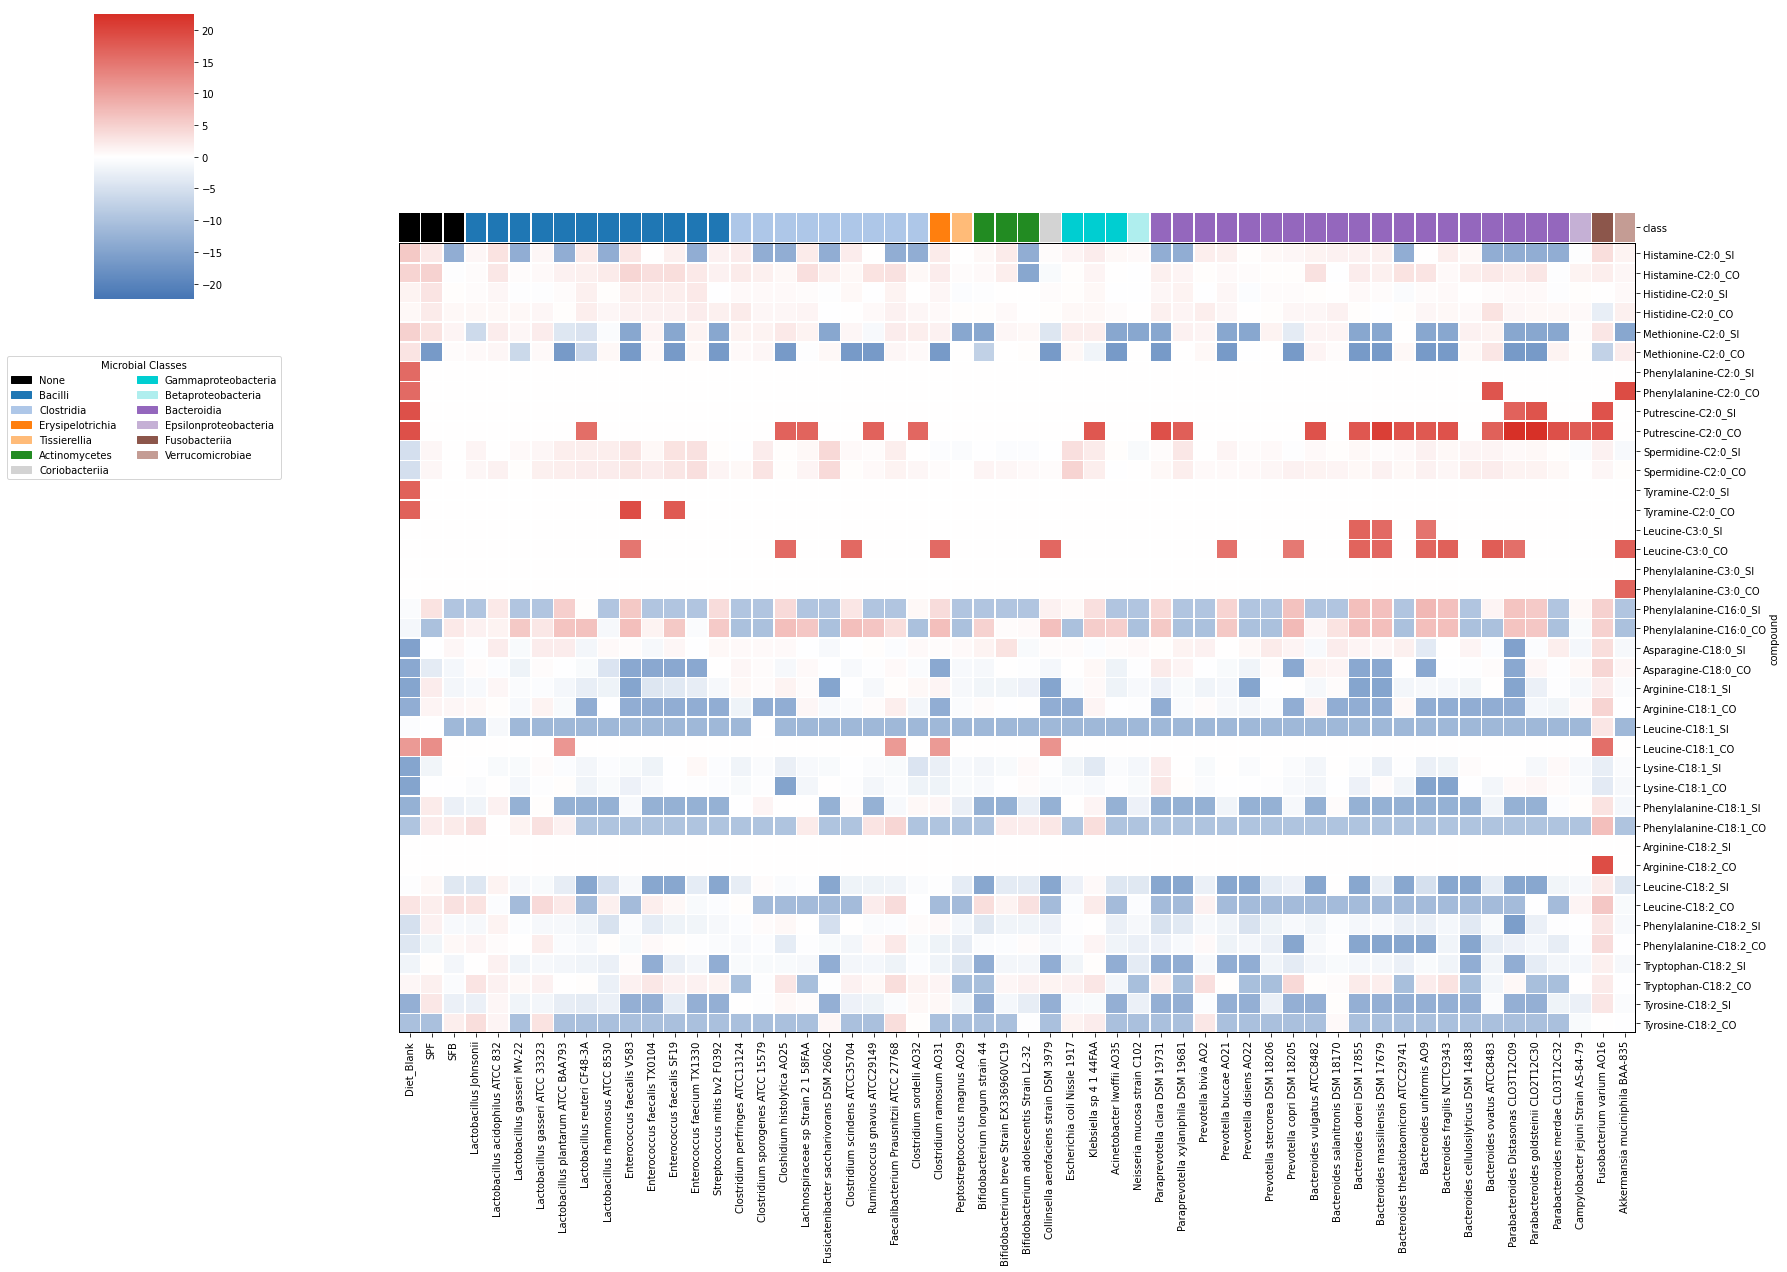

In [12]:
#plot

max_abs_value = max(df_combined_sorted.max().max(), abs(df_combined_sorted.min().min()))

fig = sns.clustermap(
    df_combined_sorted, 
    cmap=divergent_cmap,
    metric = 'braycurtis',
    col_cluster=False, 
    row_cluster=False,
    linewidths=0.5,
    linecolor = 'white',
    xticklabels=1,
    yticklabels=True,
    cbar_kws={'orientation': 'vertical'},
    vmin=-max_abs_value,
    vmax=max_abs_value,
    col_colors=col_colors
)

line_count = len(df_combined_sorted['SPF'])
fig.ax_heatmap.axhline(y=line_count, color='black', linewidth=2.0)
fig.ax_heatmap.axhline(y=0, color='black', linewidth=2.0)
fig.ax_heatmap.axvline(x=0, color='black', linewidth=2.0)
fig.ax_heatmap.axvline(x=len(df_combined_sorted.columns), color='black', linewidth=2.0)

# Add the legend
handles = [mpatches.Patch(color=class_color_mapping[cls], label=cls) for cls in unique_classes]
plt.legend(handles=handles, title='Microbial Classes', bbox_to_anchor=(0.5, -0.2), loc='upper center', borderaxespad=0., ncol=2)

plt.gcf().set_size_inches(28, 22)

plt.savefig('/.../Supplementary_Figure_3e.pdf')
plt.show()
